# Unsupervised Wisdom: Explore Medical Narratives on Older Adult Falls

    Project Outline

1. Problem Description
2. Introduction to Approach Used
3. Data Cleaning and Preprocessing
4. Exploratory Data Analysis and Data Visualization
5. Model Building
6. Final Inference

---

## 3. Data Cleaning and Preprocessing

##### Import required modules

In [40]:
import numpy as np
import pandas as pd

import json

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

##### Load the data

In [41]:
data = pd.read_csv("primary_data.csv")

#Display an overview of the data
data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,...,75,NaN,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,...,75,NaN,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,...,32,NaN,4,1,0,0,0,679,1807,0


In [42]:
rows, columns = data.shape
print(f'The data contains {rows:,} rows and {columns} columns')

The data contains 115,128 rows and 22 columns


##### Check and correct column data types

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115128 entries, 0 to 115127
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   cpsc_case_number   115128 non-null  int64  
 1   narrative          115128 non-null  object 
 2   treatment_date     115128 non-null  object 
 3   age                115128 non-null  int64  
 4   sex                115128 non-null  int64  
 5   race               115128 non-null  int64  
 6   other_race         1022 non-null    object 
 7   hispanic           115128 non-null  int64  
 8   diagnosis          115128 non-null  int64  
 9   other_diagnosis    2522 non-null    object 
 10  diagnosis_2        43145 non-null   float64
 11  other_diagnosis_2  4978 non-null    object 
 12  body_part          115128 non-null  int64  
 13  body_part_2        43145 non-null   float64
 14  disposition        115128 non-null  int64  
 15  location           115128 non-null  int64  
 16  fi

In [44]:
#Get columns that can be null
columns_null_possibility = data.dtypes[data.dtypes == 'float64'].index

#Set columns that can be null to nullable ints
data[columns_null_possibility] = data[columns_null_possibility].astype('Int64')

In [45]:
#The column data types after changes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115128 entries, 0 to 115127
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   cpsc_case_number   115128 non-null  int64 
 1   narrative          115128 non-null  object
 2   treatment_date     115128 non-null  object
 3   age                115128 non-null  int64 
 4   sex                115128 non-null  int64 
 5   race               115128 non-null  int64 
 6   other_race         1022 non-null    object
 7   hispanic           115128 non-null  int64 
 8   diagnosis          115128 non-null  int64 
 9   other_diagnosis    2522 non-null    object
 10  diagnosis_2        43145 non-null   Int64 
 11  other_diagnosis_2  4978 non-null    object
 12  body_part          115128 non-null  int64 
 13  body_part_2        43145 non-null   Int64 
 14  disposition        115128 non-null  int64 
 15  location           115128 non-null  int64 
 16  fire_involvement   1

##### Check for null values

In [46]:
#Only display columns with null values
null = data.isnull().sum()

null[null != 0]

other_race           114106
other_diagnosis      112606
diagnosis_2           71983
other_diagnosis_2    110150
body_part_2           71983
dtype: int64

There are null values present, but only occur in fields that are optional. So, they can be left without having to perform any operation on them

##### Check for duplicates

In [47]:
data.duplicated().sum()

0

This shows there are no duplicate values for each person-event pairings.   
Though, a person can have more than one record due to different fall events, but will result in different case numbers; thereby each recorded fall remains unique.

##### Variable Mapping

From the data, it shows that some columns like sex, race, e.t.c. have numeric values which can be decoded to their respective strings.   
The data is redisplayed below for easier reference

In [48]:
data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,...,75,<NA>,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,...,75,<NA>,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,...,32,<NA>,4,1,0,0,0,679,1807,0


In [49]:
#Load the variable mapping file
#with open('data/variable_mapping.json', 'r') as f:
    #mapping = json.load(f, parse_int=True)

In [50]:
with open(r'C:\Users\DELL\Desktop\variable_mapping.json') as f:
    mapping = json.load(f, parse_int=True)


In [51]:
#Overview of the variable mapping file
mapping

{'sex': {'0': 'UNKNOWN', '1': 'MALE', '2': 'FEMALE', '3': 'NON-BINARY/OTHER'},
 'race': {'0': 'N.S.',
  '1': 'WHITE',
  '2': 'BLACK/AFRICAN AMERICAN',
  '3': 'OTHER',
  '4': 'ASIAN',
  '5': 'AMERICAN INDIAN/ALASKA NATIVE',
  '6': 'NATIVE HAWAIIAN/PACIFIC ISLANDER'},
 'hispanic': {'0': 'Unk/Not stated', '1': 'Yes', '2': 'No'},
 'alcohol': {'0': 'No/Unk', '1': 'Yes'},
 'drug': {'0': 'No/Unk', '1': 'Yes'},
 'body_part': {'0': '0 - INTERNAL',
  '30': '30 - SHOULDER',
  '31': '31 - UPPER TRUNK',
  '32': '32 - ELBOW',
  '33': '33 - LOWER ARM',
  '34': '34 - WRIST',
  '35': '35 - KNEE',
  '36': '36 - LOWER LEG',
  '37': '37 - ANKLE',
  '38': '38 - PUBIC REGION',
  '75': '75 - HEAD',
  '76': '76 - FACE',
  '77': '77 - EYEBALL',
  '78': '78 - UPPER TRUNK(OLD)',
  '79': '79 - LOWER TRUNK',
  '80': '80 - UPPER ARM',
  '81': '81 - UPPER LEG',
  '82': '82 - HAND',
  '83': '83 - FOOT',
  '84': '84 - 25-50% OF BODY',
  '85': '85 - ALL PARTS BODY',
  '86': '86 - OTHER(OLD)',
  '87': '87 - NOT STATED/U

Make corrections to the decoded variables where necessary

In [52]:
#Convert the encoded values in the mapping to integers since they get read in as strings
#such as '0' to 0
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}
    
#Update the "N.S." in race to "Not Stated"
mapping['race'][0] = 'Not Stated'

#Update "Unk" term in the hispanic key to "Unknown/Not stated"
mapping['hispanic'][0] = 'Unknown/Not Stated'

#Update "No/Unk" in the alcohol, drug and location keys to "No/Unknown"
mapping['alcohol'][0] = 'No/Unknown'
mapping['drug'][0] = 'No/Unknown'

#Update "UNK" in the lcoation key to "UNKNOWN"
mapping['location'][0] = 'UNKNOWN'

#Update the fire_involvement keys
fire_updates = ['NO/UNKNOWN', 'FIRE DEPARTMENT', 'NO FIRE DEPARTMENT', 'UNKNOWN FIRE DEPARTMENT', 'MOTOR VEHICLE']
for key, update in enumerate(fire_updates):
    mapping['fire_involvement'][key] = update

In [53]:
#Overview of the variable mapping file after the updates
mapping

{'sex': {0: 'UNKNOWN', 1: 'MALE', 2: 'FEMALE', 3: 'NON-BINARY/OTHER'},
 'race': {0: 'Not Stated',
  1: 'WHITE',
  2: 'BLACK/AFRICAN AMERICAN',
  3: 'OTHER',
  4: 'ASIAN',
  5: 'AMERICAN INDIAN/ALASKA NATIVE',
  6: 'NATIVE HAWAIIAN/PACIFIC ISLANDER'},
 'hispanic': {0: 'Unknown/Not Stated', 1: 'Yes', 2: 'No'},
 'alcohol': {0: 'No/Unknown', 1: 'Yes'},
 'drug': {0: 'No/Unknown', 1: 'Yes'},
 'body_part': {0: '0 - INTERNAL',
  30: '30 - SHOULDER',
  31: '31 - UPPER TRUNK',
  32: '32 - ELBOW',
  33: '33 - LOWER ARM',
  34: '34 - WRIST',
  35: '35 - KNEE',
  36: '36 - LOWER LEG',
  37: '37 - ANKLE',
  38: '38 - PUBIC REGION',
  75: '75 - HEAD',
  76: '76 - FACE',
  77: '77 - EYEBALL',
  78: '78 - UPPER TRUNK(OLD)',
  79: '79 - LOWER TRUNK',
  80: '80 - UPPER ARM',
  81: '81 - UPPER LEG',
  82: '82 - HAND',
  83: '83 - FOOT',
  84: '84 - 25-50% OF BODY',
  85: '85 - ALL PARTS BODY',
  86: '86 - OTHER(OLD)',
  87: '87 - NOT STATED/UNK',
  88: '88 - MOUTH',
  89: '89 - NECK',
  90: '90 - LOWER AR

Map the keys to a copy of the dataframe

In [54]:
decoded_data = data.copy()

#Map the keys to the new dataframe
for col in mapping.keys():
    decoded_data[col] = decoded_data[col].map(mapping[col])
    
#Ensure mappings were applied correctly by checking that the number of missing values did not change
assert (decoded_data.isnull().sum() == data.isnull().sum()).all()

In [55]:
#An overview of the new dataset with decoded values
decoded_data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/UNKNOWN,No/Unknown,No/Unknown,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,611 - BATHTUBS OR SHOWERS,0 - None,0 - None
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,Not Stated,NaN,Unknown/Not Stated,"53 - CONTUSIONS, ABR.",NaN,...,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None


##### Data Preprocessing 1...

The narrative column can be cleaned to remove any character that isn't a word or a space, afterwards remove words that are considered stop words, replace extra spaces with just a space, while converting the texts to lower case.

In [56]:
#Make a copy of the original narrative column to a new column in case of future reference
decoded_data['narrative_original'] = decoded_data['narrative'].copy()


#Remove any character that isn't a word or a space and convert to lower case
decoded_data['narrative'] = decoded_data['narrative'].str.lower().str.replace(r'[^\w\s]',' ', regex = True)

#Remove stop words
stop_words = set(stopwords.words('english'))
decoded_data['narrative'] = decoded_data['narrative'].apply(lambda texts: ' '.join([word for word in texts.split() if word not in stop_words]))

#Remove any single character
decoded_data['narrative'] = decoded_data['narrative'].str.replace(r'\b\w\b', ' ', regex = True)

#Replace more than one occurence of spaces to just a space and also remove spaces from the beginning and end of the texts
decoded_data['narrative'] = decoded_data['narrative'].str.replace(r'\s{2,}', ' ', regex = True).str.strip()

In [57]:
#An overview of the dataset after recent changes
decoded_data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,narrative_original
0,190103269,94yom fell floor nursing home onto back head s...,2019-01-01,94,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/UNKNOWN,No/Unknown,No/Unknown,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...
1,190103270,86yom fell shower home sustained closed head i...,2019-01-01,86,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,611 - BATHTUBS OR SHOWERS,0 - None,0 - None,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...
2,190103273,87yof getting couch fell floor sustained abras...,2019-01-01,87,FEMALE,Not Stated,NaN,Unknown/Not Stated,"53 - CONTUSIONS, ABR.",NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...


##### Data Preprocessing 2...

From the recently decoded data above, the narrative column contains some redundancies, which are the age and sex which already exist in other columns.    
An example is "94YOM FELL..."

Removing these redundancies by removing any pattern similar to "94 yom" or "94yom" or "94ym" or "94yo m" or a scenario like "94yowm"

In [58]:
#Remove the redundancies
decoded_data['narrative'] = decoded_data['narrative'].str.replace(r'\d+\s*yo*\s*\w\w*\s', '', regex = True)

In [59]:
#An overview of the dataset after recent changes
decoded_data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,narrative_original
0,190103269,fell floor nursing home onto back head sustain...,2019-01-01,94,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/UNKNOWN,No/Unknown,No/Unknown,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...
1,190103270,fell shower home sustained closed head injury,2019-01-01,86,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,611 - BATHTUBS OR SHOWERS,0 - None,0 - None,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...
2,190103273,getting couch fell floor sustained abrasions e...,2019-01-01,87,FEMALE,Not Stated,NaN,Unknown/Not Stated,"53 - CONTUSIONS, ABR.",NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...


##### Data Preprocessing 3...
To have uniform narratives, each word in all narratives are converted to their base form using lemmatization

In [60]:
#Write a function to handle the lemmatization
lemmatizer = WordNetLemmatizer()

def convert_to_base(sentence):
    splitted_sentence = sentence.split()
    
    #A verb lemmatizer is used since the circumstances surrounding falls are potentially more verb-like
    sentence_base_form = ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in splitted_sentence])
    
    return sentence_base_form

Apply the lemmatization function to each narrative

In [61]:
decoded_data['narrative'] = decoded_data['narrative'].apply(lambda sentence: convert_to_base(sentence))

In [62]:
#An overview of the dataset after recent changes
decoded_data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,narrative_original
0,190103269,fell floor nurse home onto back head sustain s...,2019-01-01,94,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/UNKNOWN,No/Unknown,No/Unknown,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...
1,190103270,fell shower home sustain close head injury,2019-01-01,86,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,611 - BATHTUBS OR SHOWERS,0 - None,0 - None,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...
2,190103273,get couch fell floor sustain abrasions elbow a...,2019-01-01,87,FEMALE,Not Stated,NaN,Unknown/Not Stated,"53 - CONTUSIONS, ABR.",NaN,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...


##### Data Preprocessing 4...

From the displayed data above, some columns still have their encoded value present in their decoded value.   
An example is "62 - INTERNAL INJURY" in the diagnosis column.

Using the first data as a reference, one can derive the columns with such disparities.

In [63]:
first = decoded_data.iloc[0]

#Only display columns that start with a pattern similar to "62 - INTERNAL INJURY"
encoded_still_present = first[first.str.match(r'^\d+\s\-\s\w+') == True]

encoded_still_present

diagnosis                       62 - INTERNAL INJURY
body_part                                  75 - HEAD
disposition    4 - TREATED AND ADMITTED/HOSPITALIZED
product_1        1807 - FLOORS OR FLOORING MATERIALS
product_2                                   0 - None
product_3                                   0 - None
Name: 0, dtype: object

This pattern can be followed to remove redundancies like the digits and everything else leading up to the expected decoded value, in these columns


In [64]:
#Remove the redundancies for the observed columns
for column in encoded_still_present.index:
    decoded_data[column].replace(r'^\d+\s\-\s', '', regex = True, inplace = True)

In [65]:
#An overview of the dataset after changes
decoded_data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,narrative_original
0,190103269,fell floor nurse home onto back head sustain s...,2019-01-01,94,MALE,Not Stated,NaN,Unknown/Not Stated,INTERNAL INJURY,NaN,...,NaN,TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/UNKNOWN,No/Unknown,No/Unknown,FLOORS OR FLOORING MATERIALS,None,None,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...
1,190103270,fell shower home sustain close head injury,2019-01-01,86,MALE,Not Stated,NaN,Unknown/Not Stated,INTERNAL INJURY,NaN,...,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,BATHTUBS OR SHOWERS,None,None,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...
2,190103273,get couch fell floor sustain abrasions elbow a...,2019-01-01,87,FEMALE,Not Stated,NaN,Unknown/Not Stated,"CONTUSIONS, ABR.",NaN,...,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,No/Unknown,No/Unknown,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,None,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...


---

## 4. Exploratory Data Analysis and Data Visualization

##### Import required modules

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

#### <pre>4.1   UNIVARIATE ANALYSIS AND VISUALIZATION </pre>

##### Age Distribution

Split the ages into age groups and visualize the age groups

In [67]:
# Defining custom age bins
age_bins = [65, 71, 77, 83, 89, 95, 101, 107, 113,]  

# Define labels for the age groups
age_labels = ['65-70', '71-76', '77-82', '83-88', '89-94', '95-100', '101-106', '107-112']

# Create a new column 'age_group' based on the custom age bins
decoded_data['age_group'] = pd.cut(decoded_data['age'], bins=age_bins, labels=age_labels)

# Display the first few rows of the DataFrame with the age groups
decoded_data[['age', 'age_group']][:5]

,age,age_group
0,94,89-94
1,86,83-88
2,87,83-88
3,67,65-70
4,70,65-70


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


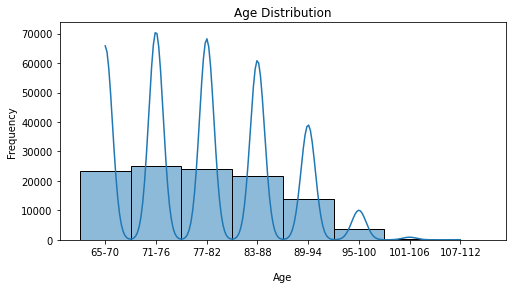

In [68]:
plt.figure(figsize=(8, 4))

sns.histplot(decoded_data['age_group'], bins = 20, kde = True)

plt.title('Age Distribution')
plt.xlabel('Age', labelpad = 15)
plt.ylabel('Frequency');

In this analysis, it becomes evident that the age distribution within the elderly population is generally between 65 to 88 years, indicating that a significant proportion of the elderly population fall within this specific range.

##### Gender Distribution

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


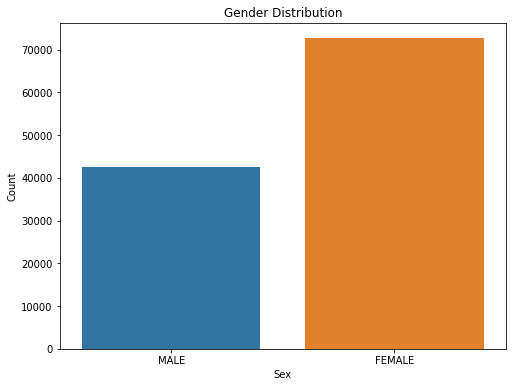

In [69]:
plt.figure(figsize=(8, 6))

sns.countplot(data = decoded_data, x = 'sex')

plt.title('Gender Distribution')
plt.xlabel('Sex')
plt.ylabel('Count');

There is a higher proportion of females than males in this dataset.

##### Race Distribution

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


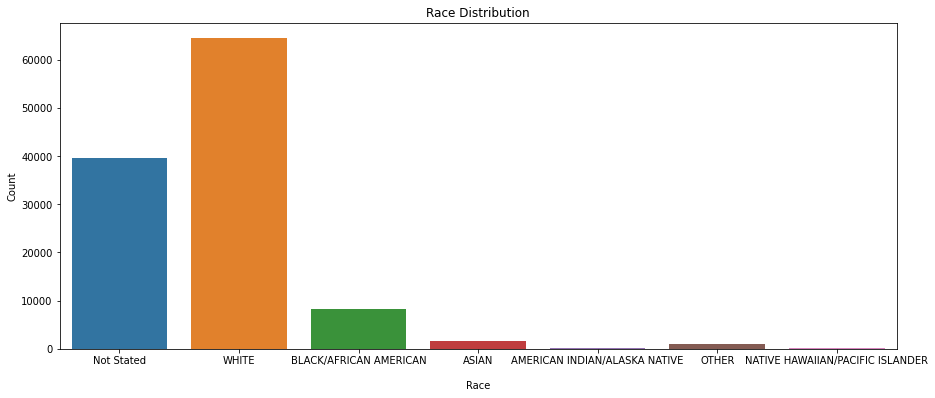

In [70]:
plt.figure(figsize=(15, 6))

sns.countplot(data = decoded_data, x = 'race')

plt.title('Race Distribution')
plt.xlabel('Race', labelpad = 15)
plt.ylabel('Count');

There is a high proportion of whites, while a considerable amount of patients' race were not stated in the dataset.

##### Diagnosis Distribution

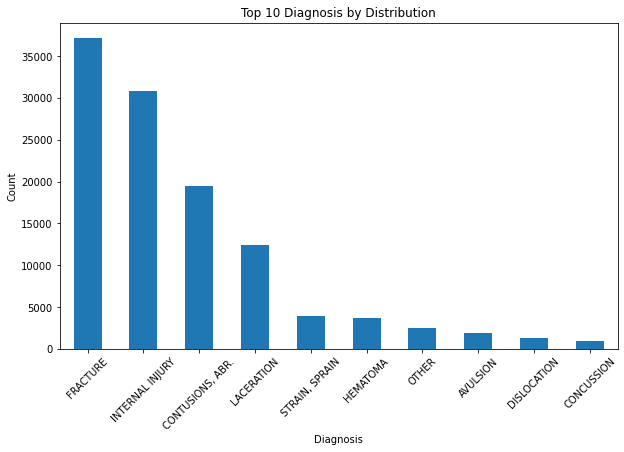

In [71]:
# Get the top 10 diagnosis 
top_10_diagnosis = decoded_data['diagnosis'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))

top_10_diagnosis.plot(kind = 'bar')

plt.title('Top 10 Diagnosis by Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.xticks(rotation=45);

These are the top 10 most frequently occurring diagnosis in this dataset, revealing the primary health conditions experienced by older individuals when they fall; with fractures being the most occuring.

##### Body Parts Distribution

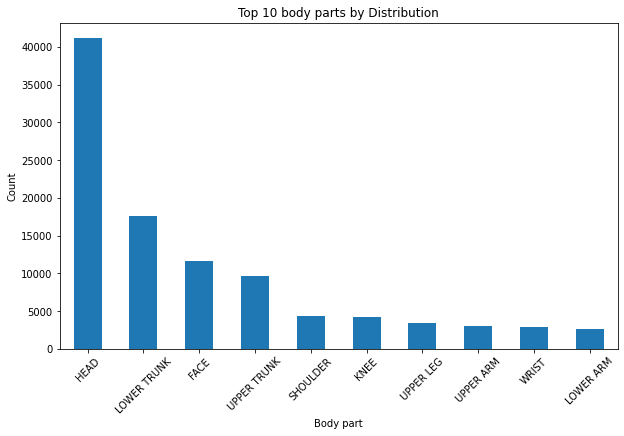

In [72]:
# Get the top 10 body parts affected by fall
top_10_body_part = decoded_data['body_part'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))

top_10_body_part.plot(kind='bar')

plt.title('Top 10 body parts by Distribution')
plt.xlabel('Body part')
plt.ylabel('Count')

plt.xticks(rotation=45);

When older individuals fall, these body parts are more susceptible to being affected with the head being the most affected.

#### <pre>4.2   BIVARIATE ANALYSIS AND VISUALIZATION (with detailed insights)</pre>

This starts with analysing factors specific to individuals; like Age, Sex and Race   
Then moving on to environmental factors; specifically Location   
And then, analysing intake of substances around the duration of the fall; such as Drugs and Alcohol. 

##### Demographic Factors (Age vs Diagnosis)

In [73]:
#Get the data that matches with the top 10 diagnosis
top_10_diagnosis = decoded_data['diagnosis'].value_counts().head(10).index
decoded_data_filtered = decoded_data[decoded_data['diagnosis'].isin(top_10_diagnosis)]

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


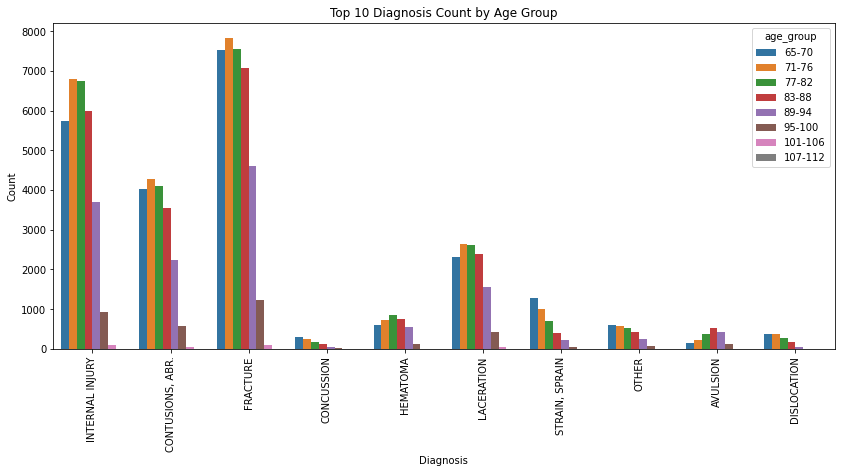

In [74]:
#Plot the data
plt.figure(figsize=(14, 6))

sns.countplot(data = decoded_data_filtered, x = 'diagnosis', hue = 'age_group')

plt.title('Top 10 Diagnosis Count by Age Group')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.xticks(rotation=90);

- ##### Insights on age-related injury trends: 

The data reveals clear age-related patterns in the types of injuries diagnosed after falls. As individuals advance in age, they exhibit distinct injury patterns, highlighting the importance of age as a risk factor for certain types of injuries.

Increased Risk of Internal Injuries (Ages 71-82): The finding that people between the ages of 71 and 82 are more frequently diagnosed with internal injuries following falls suggests that this age group may be particularly susceptible to injuries affecting internal organs. This vulnerability might be linked to age-related physiological changes or underlying health conditions.

Contusions and Auditory Brainstem Response (ABR) in Older Age Groups (Ages 65-82): The higher incidence of contusions (bruises) and the presence of auditory brainstem response (ABR) diagnoses within the age range of 65 to 82 indicate that falls in this age group not only result in physical injuries but may also have neurological or auditory implications. This finding underscores the need for a holistic assessment of falls in older adults.

Elevated Fracture Rates (Ages 65-88): The significant prevalence of fractures among individuals aged 65 to 88, with a notably higher rate, underscores the heightened risk of bone fractures in older age. This increased susceptibility might be attributed to factors such as reduced bone density and diminished musculoskeletal strength, which amplify the risk of fractures during falls.

##### Gender Factors (Sex vs Diagnosis)

This compares the genders against the top three diagnosis

In [75]:
#Get the data that matches with the top 3 diagnosis
top_3_diagnosis = decoded_data['diagnosis'].value_counts().head(3).index
decoded_data_filtered_2 = decoded_data[decoded_data['diagnosis'].isin(top_3_diagnosis)]

Create the data for a percentage stacked bar chart

In [76]:
# Calculate the proportions of each diagnosis by gender
diagnosis_by_sex = decoded_data_filtered_2.groupby(['sex', 'diagnosis']).size() / decoded_data_filtered_2.groupby('sex').size()

# Reset the index for the proportions
diagnosis_by_sex = diagnosis_by_sex.reset_index(name = 'Proportion')

# Pivot the data to create a percentage stacked bar chart
pivot_table = diagnosis_by_sex.pivot(index = 'sex', columns = 'diagnosis', values = 'Proportion')

# Normalize the data to percentages (multiply by 100)
pivot_table *= 100

Plot the visualization

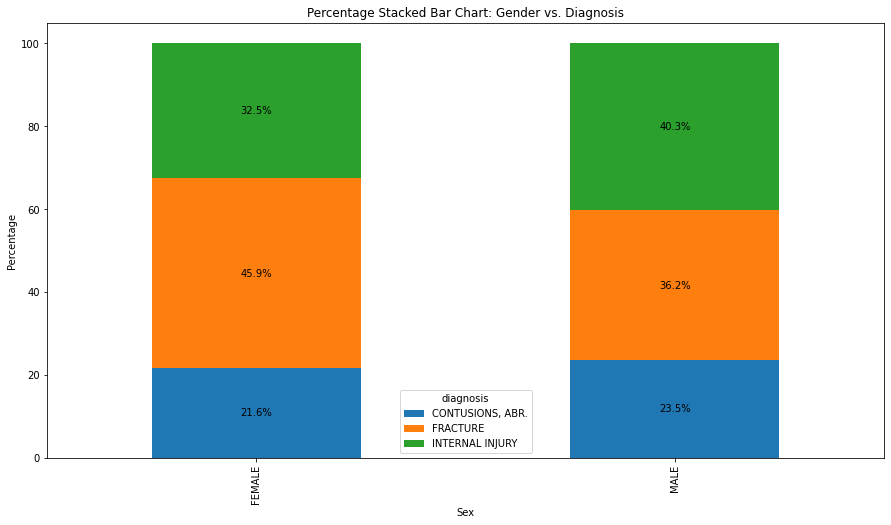

In [77]:
# Plot the percentage stacked bar chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(15, 8))

plt.xlabel('Sex')
plt.ylabel('Percentage')
plt.title('Percentage Stacked Bar Chart: Gender vs. Diagnosis')

# Add data labels to each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')

- ##### Insights on gender-specific injury patterns:

The data reveals gender-specific patterns in the types of injuries diagnosed after falls. These differences highlight the importance of considering gender as a factor in understanding and addressing specific health outcomes.

Higher Incidence of Internal Injury in Males: The higher occurrence of internal injury diagnoses in males suggests that men may be more susceptible to injuries affecting internal organs following falls. This finding may be indicative of gender-related physiological differences or variations in injury mechanisms.

Contusion and Auditory Brainstem Response (ABR) in Males: The prevalence of contusion and auditory brainstem response (ABR) diagnoses in males implies that men are more likely to experience bruises or minor injuries and may also be at greater risk of auditory or neurological issues following falls.

Fractures More Common in Females: The observation that fractures are diagnosed more frequently in females suggests that women may face a higher risk of bone fractures during falls. This could be influenced by factors such as bone density, physical activity, or age-related changes affecting bone health.

##### Racial Factors (Race vs Diagnosis)

This compares the races against the top three diagnosis

In [78]:
# Calculate the proportions of each diagnosis by race
diagnosis_by_race = decoded_data_filtered_2.groupby(['race', 'diagnosis']).size() / decoded_data_filtered_2.groupby('race').size()

# Reset the index for the proportions
diagnosis_by_race = diagnosis_by_race.reset_index(name = 'Proportion')

# Pivot the data to create a percentage stacked bar chart
pivot_table_2 = diagnosis_by_race.pivot(index = 'race', columns = 'diagnosis', values = 'Proportion')

# Normalize the data to percentages (multiply by 100)
pivot_table_2 *= 100

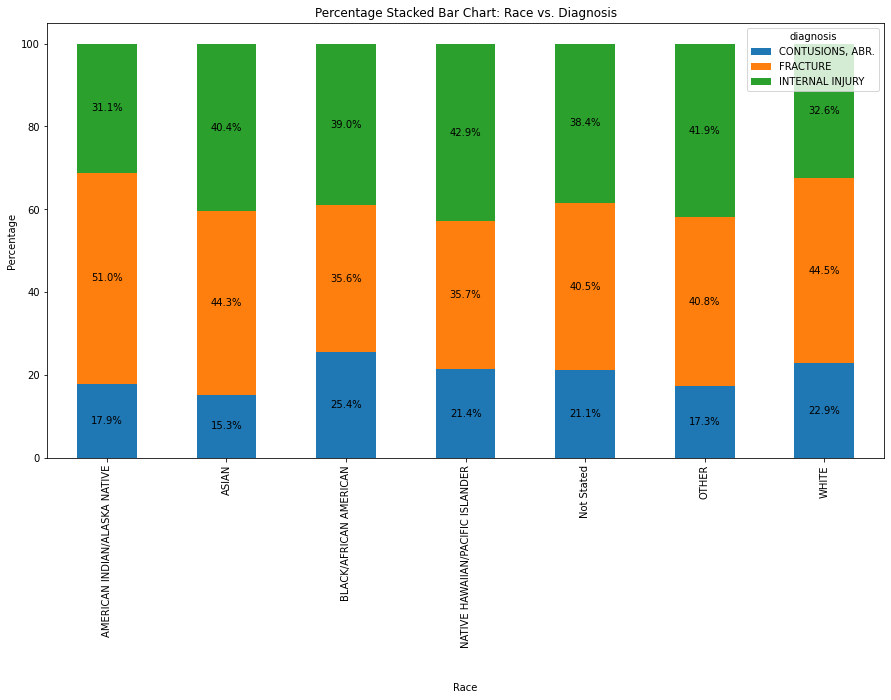

In [79]:
#Plot the percentage stacked bar chart
ax = pivot_table_2.plot(kind = 'bar', stacked = True, figsize = (15, 8))

# Add labels and a title
plt.xlabel('Race', labelpad = 35)
plt.ylabel('Percentage')
plt.title('Percentage Stacked Bar Chart: Race vs. Diagnosis')

# Add data labels to each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')

- ##### Insights on racial disparities in diagnosis patterns: 

The data indicates that there are disparities in the types of diagnoses individuals receive following falls among different racial groups. These disparities may reflect variations in healthcare access, socioeconomic factors, or underlying health conditions within these populations.

Higher Occurrence of Internal Injuries in Native Hawaiian/Pacific Islander: The higher incidence of internal injury diagnoses in the Native Hawaiian/Pacific Islander group suggests that individuals from this racial background may be more susceptible to injuries affecting internal organs after falling. Further research is needed to understand the specific factors contributing to this pattern.

Contusions and Auditory Brainstem Response (ABR) in Black/African American: The prevalence of contusion and auditory brainstem response (ABR) diagnoses in the Black/African American population may indicate that falls in this racial group not only result in physical injuries (contusions) but may also have neurological or auditory implications (ABR). This finding underscores the need for comprehensive assessments and care for fall-related injuries in this demographic.

Fractures More Common in American Indian/Alaska Native: The observation that fractures are diagnosed more frequently in the American Indian/Alaska Native population suggests that individuals from this racial background may be at a higher risk of bone fractures following falls. Factors contributing to this risk may include variations in bone health, activity levels, or other sociocultural factors.

##### Environmental Factors 1 (Location vs Diagnosis)

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

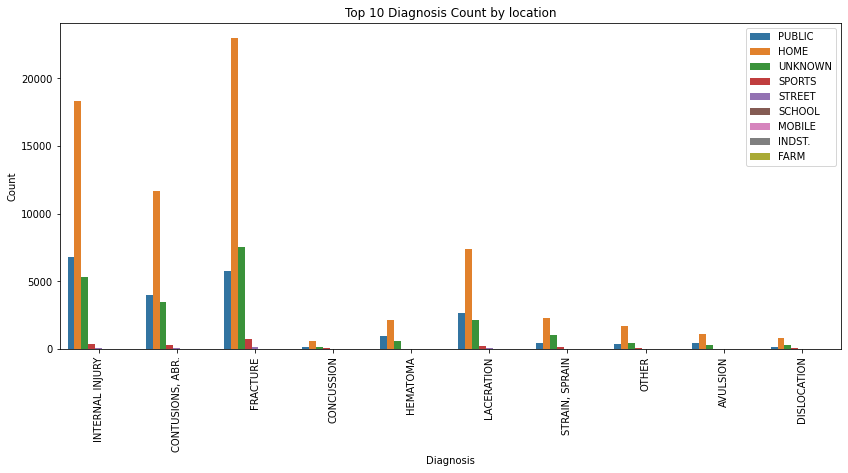

In [80]:
plt.figure(figsize=(14, 6))

sns.countplot(data = decoded_data_filtered, x = 'diagnosis', hue = 'location')

plt.title('Top 10 Diagnosis Count by location')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.legend(loc = 'upper right')
plt.xticks(rotation=90);

- ##### Insights on fall diagnosis by location

The observation that most falls occur at home, unknown locations, and in public areas provides valuable insights into fall prevention and safety measures. Here are insights and potential solutions based on this observation:

Home as a Common Location: The fact that a significant number of falls occur at home underscores the importance of home safety for individuals of all ages, particularly for older adults who may spend a substantial amount of time at home. This highlights the need to encourage home safety assessments, particularly for older adults, to identify and address potential fall hazards at home. This may include removing tripping hazards, improving lighting, installing handrails, and making bathrooms more accessible.

Public Spaces: Falls in public areas highlight the need for public safety measures and awareness campaigns to reduce the risk of falls in crowded places.

Unknown Locations: The "unknown location" category may indicate that some falls happen in unmonitored or less-traveled areas, making it challenging to identify and respond to these incidents promptly. A solution can be for older adults to get guides which can help them navigate unknown locations

##### Environmental Factors 2 (Location vs Disposition)

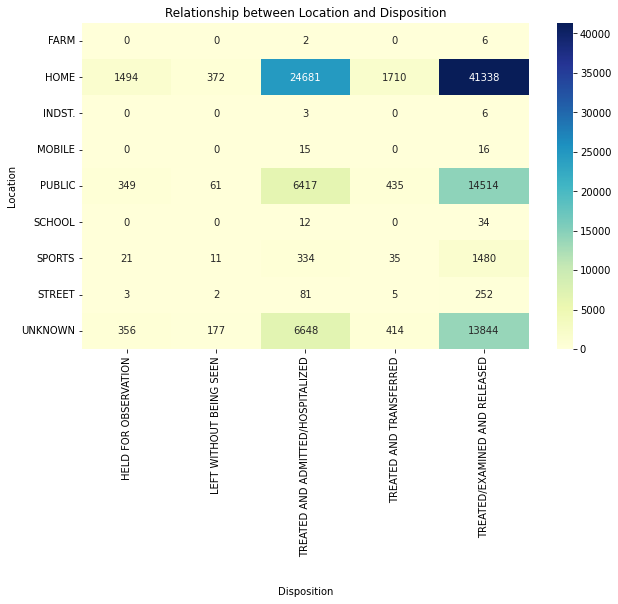

In [81]:
# Visualize the relationship between location and disposition using a heatmap
plt.figure(figsize=(10, 6))

location_disposition_cross_tab = pd.crosstab(decoded_data['location'], decoded_data['disposition'])
sns.heatmap(location_disposition_cross_tab, annot = True, fmt = 'd', cmap = 'YlGnBu')

plt.title('Relationship between Location and Disposition')
plt.xlabel('Disposition', labelpad = 30)
plt.ylabel('Location');

- ##### Insights on fall disposition by location

Falls at home are more common but result in a mix of treatment outcomes: a significant number of individuals are treated and released, while a substantial number require hospitalization, but the **"treated and transferred"** and **"left without being seen"** caught our attention. Why?

- ##### Extra Insights on the "treated and transferred" disposition
Here are some possible interpretations regarding the "treated and transferred" disposition:

1. Severity of Condition: Individuals who were "treated and transferred" may have had medical conditions or injuries that required immediate treatment in one healthcare facility but needed specialized care or further evaluation at another facility. This suggests that their conditions were of a moderate to high severity.

2. Availability of Specialized Services: The initial healthcare facility where they were treated might not have had the specialized equipment, expertise, or resources needed to fully address their medical condition. Therefore, they were transferred to a different facility where such resources were available.

3. Hospital-to-Hospital Transfer: It could mean that patients were initially brought to a general hospital, but their condition required treatment at a specialized hospital or trauma center. These transfers are common for cases like severe trauma, stroke, or cardiac events.

4. Interfacility Transfer: In some cases, patients might be transferred from one healthcare facility to another within a healthcare network for continuity of care or access to specialized services like surgery or intensive care.

5. Insurance or Coverage Considerations: The choice to "treat and transfer" might also be influenced by insurance coverage or the patient's financial situation. Some treatments might be initiated at one facility to stabilize the patient before they are transferred to a different facility that is in-network or covered by their insurance.

Incorporating this insight into this analysis allows for a more comprehensive understanding of the healthcare landscape, patient outcomes, and the factors that influence medical decision-making. It helps to assess the effectiveness and efficiency of the healthcare system and can guide improvements in patient care and resource allocation.

- #### Extra Insights on the "left without being seen" disposition
With most falls occuring at home, public and in unknown places, some patients who arrive at the hospital are still "left without being seen," this raises some concerns both patient-wise and hospital-wise. Here are several possible interpretations:

1. Patient Discontent: Patients may have left without being seen due to dissatisfaction with the healthcare facility, long wait times, or perceived poor quality of care. This could indicate issues with patient experience and satisfaction.

2. Walk-Outs: "Left without being seen" often refers to patients who arrived at a healthcare facility (such as an emergency department) but left before receiving any medical evaluation or treatment. This might happen if they felt their condition improved, they couldn't wait any longer, or they thought their condition was not serious.

3. Resource Constraints: Healthcare facilities, particularly emergency departments, may face resource constraints, leading to long wait times and the inability to see all patients promptly. Some patients may leave due to these resource limitations.

4. Urgency Assessment: Patients who "left without being seen" may have initially perceived their condition as urgent but later reconsidered or received advice from others that their condition was not severe. This indicates changes in the perceived urgency of their health issues.


Healthcare professionals have **legal and ethical obligations** to ensure that patients receive appropriate care. "Left without being seen" cases raise questions about whether these obligations were met.

To fully understand the meaning and implications of patients leaving without being seen, it's essential to investigate the specific circumstances, including the diagnosis or presenting complaints of these patients, the timing of their departure, and any factors contributing to their decision. Such an analysis can help healthcare facilities identify opportunities for improvement in patient care, satisfaction, and operational efficiency. Additionally, it can lead to strategies for reducing patient walk-outs and ensuring that patients receive the care they need in a timely and appropriate manner.

- #### Extra Insights on the "left without being seen" disposition 2
Patients who are "left without being seen" can become discontented or dissatisfied with medical care and this can have significant implications for both patients and healthcare providers. Addressing this disposition is crucial to improving the quality of care, patient experience, and overall healthcare outcomes. Here are some implications and strategies to tackle it:

    **Implications:**

1. Negative Patient Outcomes: Discontented patients may delay seeking medical care, follow-up appointments, or necessary treatments, which can lead to worsened health conditions and outcomes.

2. Reduced Trust: Dissatisfied patients may lose trust in healthcare providers and institutions, making them less likely to adhere to medical advice or recommendations.

3. Impact on Reputation: Negative patient experiences can damage the reputation of healthcare facilities and healthcare providers, affecting their ability to attract and retain patients.

4. Decreased Patient Compliance: Discontent can result in decreased patient compliance with prescribed medications, treatment plans, and lifestyle recommendations.

5. Litigation Risk: Unhappy patients are more likely to consider legal action in cases of perceived medical malpractice or negligence, leading to increased legal risks for healthcare providers.

6. Decreased Patient Retention: Patients who are dissatisfied with their healthcare experience may seek care elsewhere, leading to a loss of patient retention and revenue for healthcare facilities.

**Strategies to Tackle Patient Leaving without being seen**:

1. Improve Communication: Effective communication between healthcare providers and patients is essential. Encourage open and empathetic communication, active listening, and clear explanation of diagnoses, treatment options, and expectations.

2. Enhance Patient-Centered Care: Shift the focus to patient-centered care, where patients are actively involved in decision-making regarding their health and treatment plans. Involve patients in care discussions and respect their preferences.

3. Reduce Wait Times: Implement strategies to reduce waiting times in healthcare facilities, such as appointment scheduling improvements, efficient patient flow, and optimized resource allocation.

4. Enhance Staff Training: Provide healthcare staff with training in patient communication, empathy, and cultural competence to ensure positive patient interactions.

5. Quality Improvement Initiatives: Continuously monitor and assess the quality of care through patient satisfaction surveys, feedback mechanisms, and performance evaluations. Use data to identify areas for improvement.

6. Patient Advocacy Programs: Establish patient advocacy programs to assist patients in navigating the healthcare system, addressing concerns, and ensuring their needs are met.

7. Transparency: Be transparent about healthcare costs, treatment options, and potential risks. Patients appreciate transparency in billing and treatment decisions.

8. Complaint Resolution: Develop clear and efficient mechanisms for addressing patient complaints and grievances. Ensure that patients know how to voice their concerns and that their feedback is taken seriously.

9. Staff Well-Being: Recognize that healthcare staff well-being is closely tied to patient satisfaction. Support and engage healthcare providers to prevent burnout and maintain a positive work environment.

10. Technology Integration: Leverage technology to improve patient experiences, such as online appointment scheduling, telehealth options, and electronic health records for easy access to medical information.

11. Cultural Competency: Train healthcare providers to be culturally competent and sensitive to the diverse needs and backgrounds of patients.

12. Patient Education: Empower patients with information about their health conditions and treatment plans. Ensure they understand their role in managing their health.

13. Continuous Feedback Loop: Establish a continuous feedback loop with patients to gather input and make improvements based on their suggestions and concerns.

Addressing patient discontent is an ongoing process that requires a commitment to patient-centered care, quality improvement, and a culture of empathy and responsiveness within the healthcare sector. By taking proactive steps to enhance patient satisfaction and address patient concerns, healthcare providers and institutions can improve patient outcomes and maintain their reputation.

##### Alchohol Intake Factors (Alcohol vs Diagnosis)

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

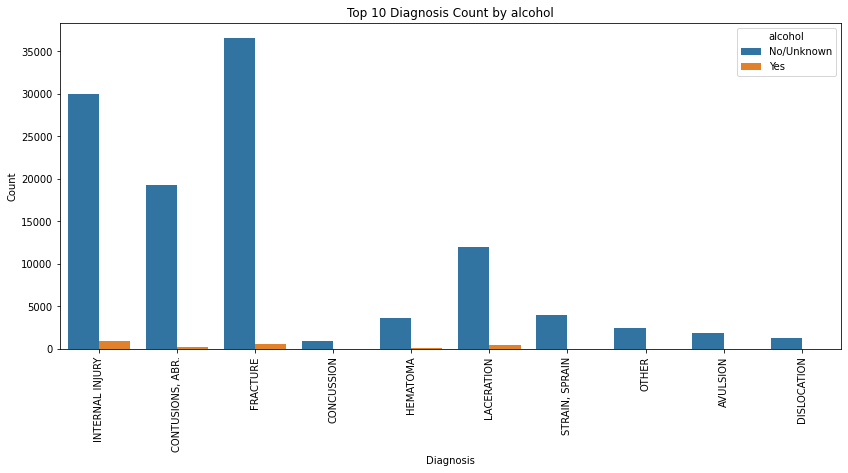

In [82]:
plt.figure(figsize=(14, 6))

sns.countplot(data=decoded_data_filtered, x='diagnosis', hue='alcohol')

plt.title('Top 10 Diagnosis Count by alcohol')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.xticks(rotation=90);

- ##### Insights on falls based on alchohol intake
The visualization shows that most falls aren't caused by alcohol intake.

##### Drug Intake Factors (Drugs vs Diagnosis)

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

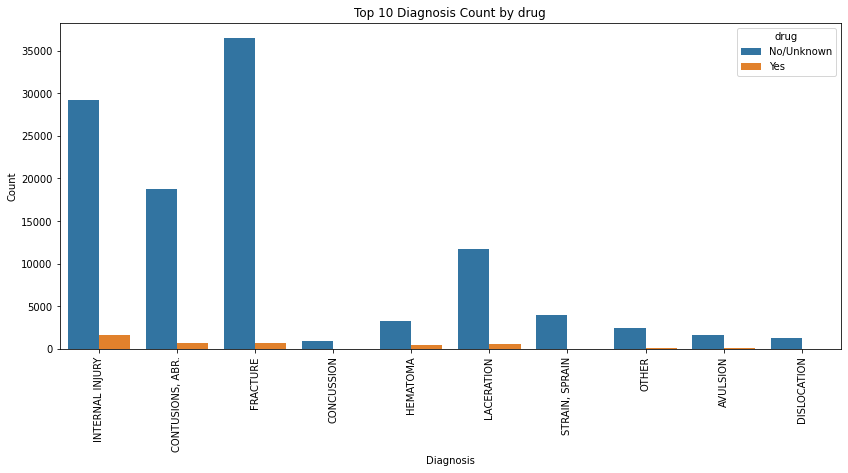

In [83]:
plt.figure(figsize=(14, 6))

sns.countplot(data=decoded_data_filtered, x='diagnosis', hue='drug')

plt.title('Top 10 Diagnosis Count by drug')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.xticks(rotation=90);

- ##### Insights on falls based on drug intake
This visualization shows that most of the falls are not caused by drugs as well

#### After checking out the factors relating to each patient, it's imperative to analyze the body parts most affected and also identify the common circumstances or activities during which falls occur among older adults 

##### Body Parts Most Affected (Body Part vs Diagnosis)

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

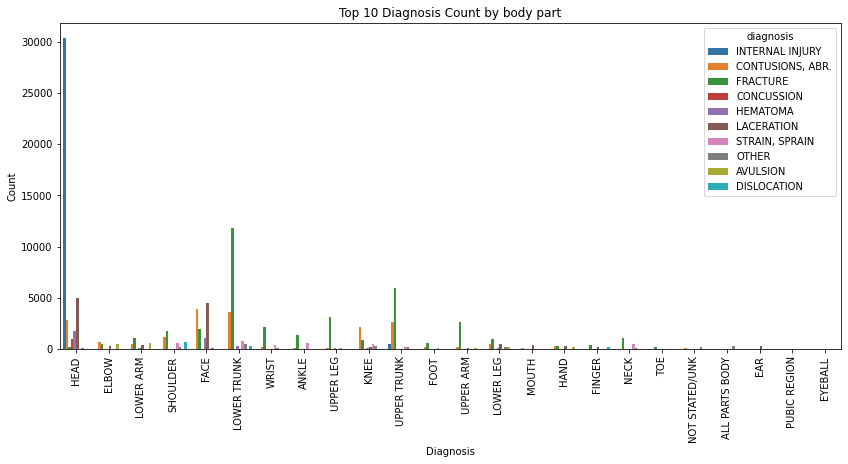

In [90]:
plt.figure(figsize=(14, 6))

sns.countplot(data=decoded_data_filtered, x='body_part', hue='diagnosis')

plt.title('Top 10 Diagnosis Count by body part')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.xticks(rotation=90);

### The observation that older adults who fall and hit their head are more likely to have internal injuries, while those who hit their lower trunk are more likely to have fractures, indicates valuable insights that can inform both preventive measures and response strategies. Here are some insights and potential solutions derived from this observation:

**Insights:**

1. **High-Risk Areas:** The observation highlights specific body parts (head and lower trunk) as high-risk areas for older adults during falls. Understanding these high-risk areas is crucial for injury prevention.

2. **Common Injuries:** It identifies the most common types of injuries associated with falls in older adults, which are internal injuries and fractures.

3. **Correlation:** The strong correlation between the location of impact and the type of injury suggests a predictive relationship that can be valuable for early intervention and risk assessment.

**Solutions:**

1. **Fall Prevention Strategies:** Implement targeted fall prevention strategies that focus on reducing the risk of falls in older adults. These strategies may include:
   - **Home Safety:** Evaluate and improve home safety, removing hazards that could lead to falls.
   - **Exercise Programs:** Encourage older adults to participate in balance and strength training exercises to improve stability and reduce the risk of falling.
   - **Medication Management:** Review and adjust medications that may cause dizziness or unsteadiness.
   - **Vision Checks:** Ensure regular vision checks to correct any visual impairments that may contribute to falls.
   - **Footwear:** Promote appropriate footwear with good traction to prevent slipping.

2. **Education and Awareness:** Increase awareness among older adults and their caregivers about the risks associated with falls. Provide information about what to do in case of a fall and the importance of seeking medical attention, especially when head or trunk injuries occur.

3. **Early Assessment:** Encourage healthcare professionals to conduct thorough assessments after a fall, particularly focusing on head and lower trunk injuries. Rapid assessment can lead to early diagnosis and treatment, potentially reducing the severity of injuries.

4. **Fall Detection Devices:** Consider using fall detection devices or systems that can automatically detect falls and alert caregivers or emergency services. These devices can be especially helpful for individuals at high risk of falls.

5. **Medical Protocols:** Develop or update medical protocols for healthcare providers to ensure a comprehensive evaluation of older adults who have fallen, including imaging and diagnostic tests for head and trunk injuries.

6. **Supportive Care:** For older adults with a history of falls, offer supportive care and services that can help them maintain independence while minimizing risks. This may include home healthcare, rehabilitation, or assisted living options.



Remember that addressing fall-related risks and injuries in older adults is a multidisciplinary effort involving healthcare providers, caregivers, community organizations, and policymakers. These insights and solutions aim to enhance the safety and well-being of older adults and reduce the impact of falls on their health and quality of life.

#### Common circumstances surrounding falls among older adults 

A biagram is used here to analyze the 15 most common bigrams in the narrative column

In [91]:
#Import required modules
from nltk.tokenize import word_tokenize
from nltk import bigrams

from collections import Counter

Grab the 15 most common bigrams

In [92]:
# Initialize a list to store preprocessed bigrams
preprocessed_bigrams = []

#Extract biagrams from each narrative
for sentence in decoded_data['narrative']:
    # Tokenize the sentence
    tokens = word_tokenize(sentence)
    
    # Create bigrams from the tokens
    bigrams_list = list(bigrams(tokens))
    
    # Append the preprocessed bigrams to the list
    preprocessed_bigrams.extend(bigrams_list)

# Count the frequency of each bigram
bigram_counts = Counter(preprocessed_bigrams)

# Get the top 15 most common bigrams and their counts
top_15_bigrams = bigram_counts.most_common(15)
bigram_labels, bigram_counts = zip(*top_15_bigrams)

Visualize the bigrams

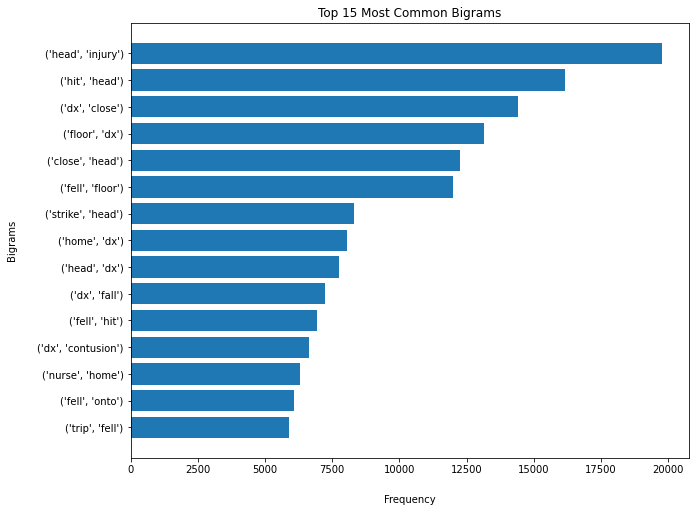

In [93]:
# Create a bar chart to visualize bigram frequencies
plt.figure(figsize=(10, 8))

plt.barh(range(len(bigram_labels)), bigram_counts)
plt.yticks(range(len(bigram_labels)), bigram_labels)

plt.xlabel('Frequency', labelpad = 20)
plt.ylabel('Bigrams', labelpad = 20)
plt.title('Top 15 Most Common Bigrams')

plt.gca().invert_yaxis()  # Invert the y-axis to display the most common at the top

- ##### Insights on common circumstances surrounding older adult falls
The bigrams provide insights into the reasons older adults fall while also noting the body part affected and also place of fall in some scenarios. Let's analyze each bigram and suggest potential solutions for fall prevention:

1. **Head Injury**: The presence of "head injury" indicates that head injuries are a significant outcome of falls among older adults. It's essential to focus on strategies to prevent head injuries, such as using protective headgear and implementing fall prevention programs.

2. **Hit Head**: Falls that lead to "hit head" indicate a potential problem with balance or coordination. Solutions may involve balance exercises, regular vision check-ups, and environmental modifications to reduce hazards.

3. **Close Head**: "Close head" could refer to injuries where the skull is not fractured but may still result in concussions or other head injuries. Preventive measures may include education on recognizing the signs of head injuries and seeking medical attention.

4. **Fell Floor**: "Fell floor" suggests that falls often result in individuals landing on the floor. This emphasizes the importance of strategies to minimize the impact of falls, including improving flooring materials to reduce injury risk.

5. **Strike Head**: Similar to "hit head," this bigram points to falls leading to head injuries. Strategies to reduce head injuries are relevant here.

6. **Fell Hit**: "Fell hit" represents falls that result in the older adults having their body part(s) hit an object. Fall prevention strategies should be implemented broadly, including home safety measures and regular exercise.

7. **Nurse Home**: The mention of "nurse home" suggests that falls occur in care facilities. Solutions may involve improved staff training, fall risk assessments, and environmental modifications in nursing homes.

8. **Fell Onto**: "Fell onto" highlights the presence of objects in the path of the older adults. Solutions may involve regular vision check-ups, and environmental modifications to reduce hazards.

9. **Trip Fell**: "Trip fell" highlights the role of tripping hazards in falls. Reducing tripping hazards, such as clutter and loose rugs, can help prevent falls.

10-15 which includes unique words such as dx, close, floor, home, head, fall, and contusion further highlight the listed bigrams insight above. An addition is that the presence of dx showcases diagnoses made by the abstractors, the term "home" showcases that some falls do occur at home and "contusions" highlight the fact that some falls do lead to contusions.

<pre>

</pre>
Based on these insights, here are some potential solutions for fall prevention among older adults:

1. **Fall Risk Assessments**: Conduct regular fall risk assessments for older adults, taking into account their health conditions, mobility, and living environment.

2. **Home Safety Modifications**: Promote home safety assessments and modifications, such as installing handrails, improving lighting, and removing tripping hazards.

3. **Balance and Strength Training**: Encourage older adults to engage in balance and strength training exercises to improve their physical stability and reduce the risk of falling.

4. **Medication Management**: Review and manage medications that may cause dizziness or affect balance, consulting with healthcare professionals as needed.

5. **Use of Mobility Aids**: Provide and educate older adults on the appropriate use of mobility aids such as walkers or canes.

6. **Regular Health Checkups**: Encourage older adults to have regular checkups with healthcare providers to address any underlying health issues that may contribute to falls.

7. **Educational Programs**: Offer educational programs to raise awareness about fall prevention, including information on recognizing fall risks and taking preventive measures.

8. **Environmental Modifications in Nursing Homes**: Improve the safety of nursing homes by implementing environmental modifications and staff training programs.

9. **Protective Headgear**: For older adults at risk of head injuries due to falls, consider the use of protective headgear, such as helmets or head protection.

10. **Regular Vision Exams**: Encourage older adults to have regular vision exams to ensure proper vision, which is crucial for balance and coordination.

Implementing a combination of these solutions tailored to individual needs and circumstances can significantly reduce the risk of falls among older adults and enhance their overall safety and well-being. Additionally, fostering a supportive and vigilant community or caregiver network can further contribute to fall prevention.

---

## 5. Model Building